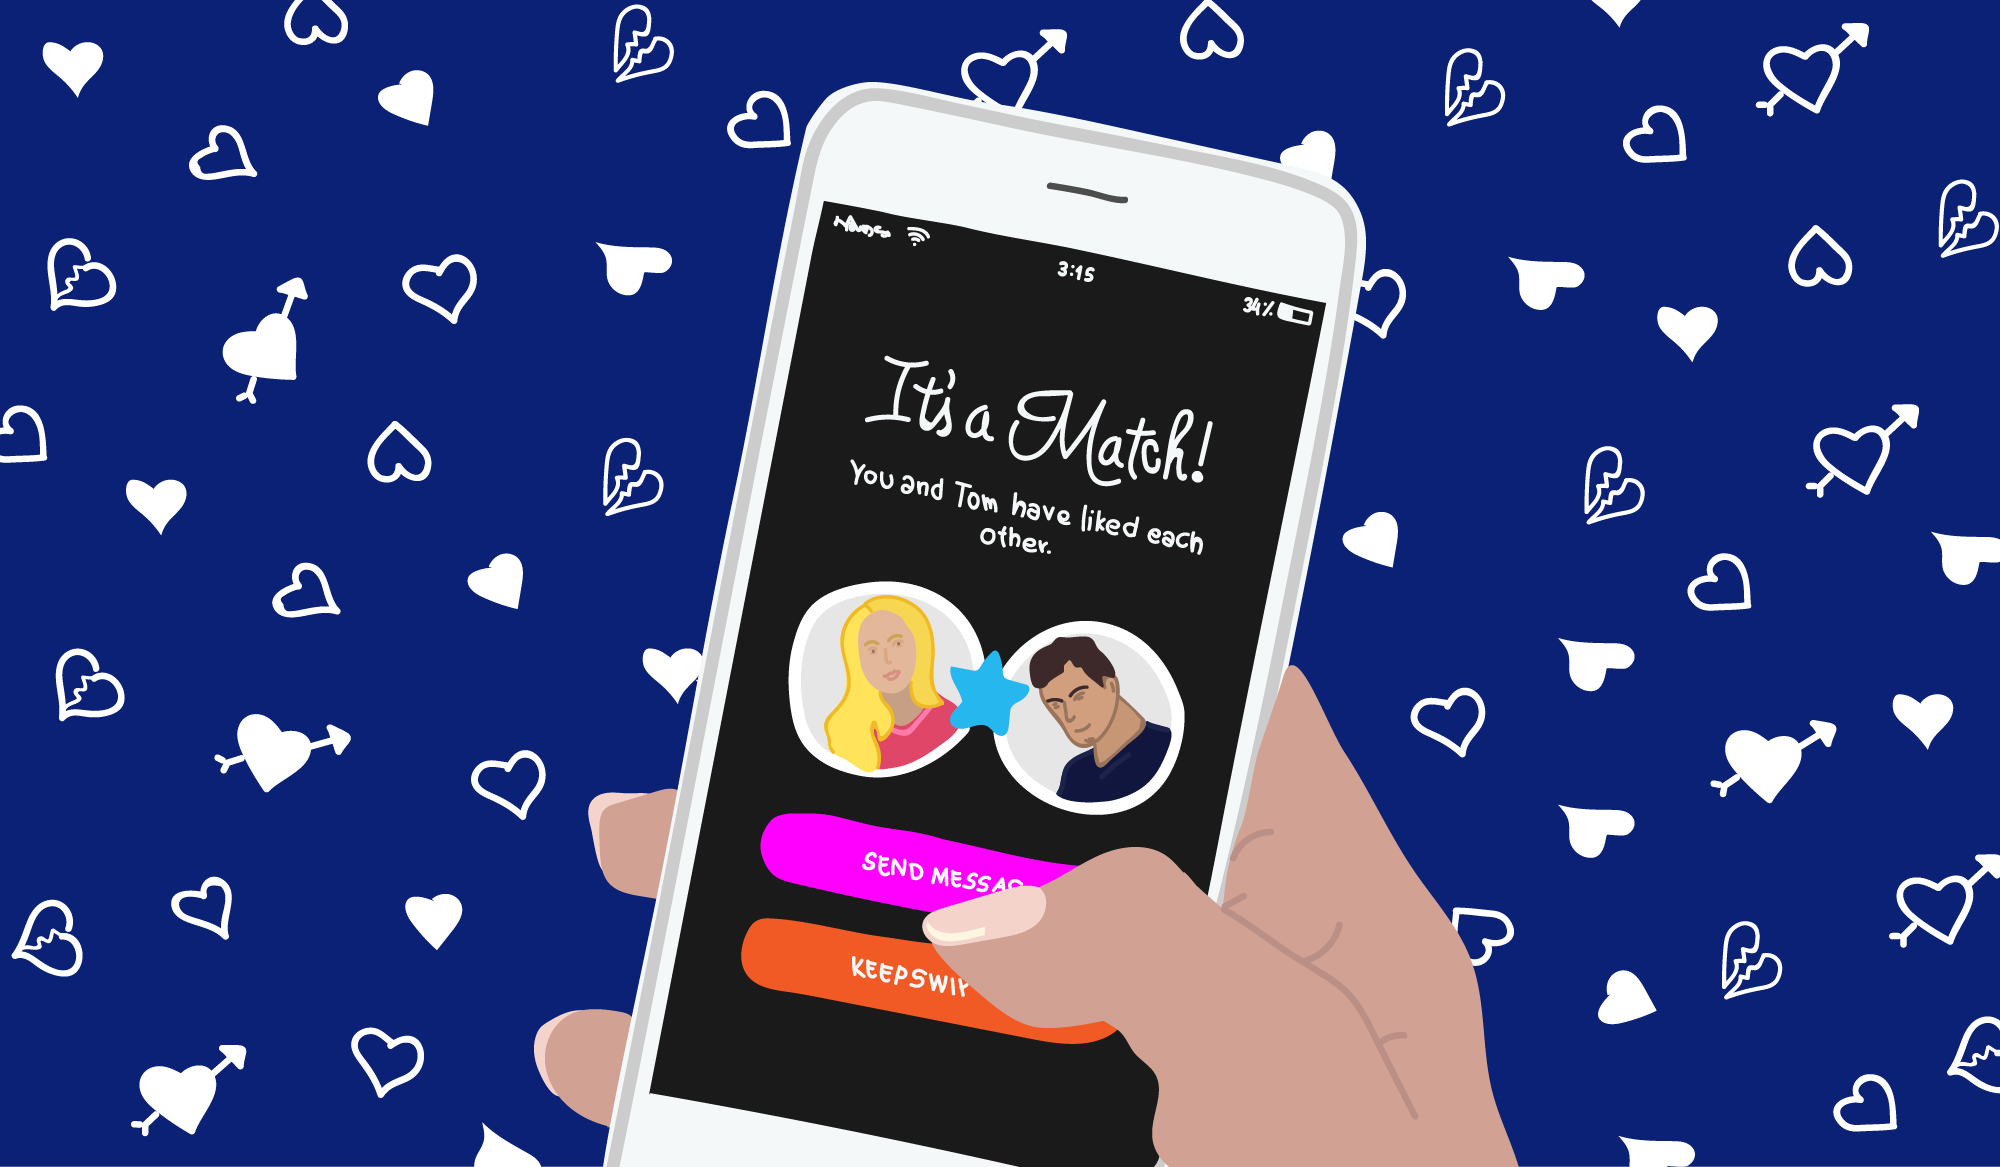

# Sentiment Analysis of Dating App Reviews

### A specific look at Bumble, Hinge, & Tinder

The dating app industry is growing, but there seem to be a lot of negative sentiments around dating apps. I'm using a dataset of Tinder, Bumble, and Hinge reviews to break down these positive and negative feelings. My final Linear SVC model was able to get an 87% accuracy.

In [139]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf
import string
import os
import sys
import re
import nltk
import itertools
from keras.utils import to_categorical
from tensorflow import keras
from nltk import WordNetLemmatizer, pos_tag 
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.python import pywrap_tensorflow

from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
from wordcloud import WordCloud
from absl import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aheinke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/aheinke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Business Understanding and Data Understanding

There were 366 million dating app users in 2022, up from 324 million in 2021, so this almost $6 billion dollar industry is continuing to grow. However, 88% of users are disatisfied with what they find on dating apps and they have been touted as one of the main causes of depression, anxiety, stress, and body dissatisfaction. Where are all these apps going wrong and what can they be doing better? Based on reviews, is the sentiment around the top dating apps truly this negative?

To dig deeper into this, I am using a dataset from Kaggle, which contains about 682,000 reviews from 2017-2022 on Tinder, Bumble, and Hinge. Each row of this dataset included:
'Name' = the users name
'Review' = the users review of the app
'Rating' = the users rating of the app 
'#ThumbsUp' = shows how many times other users "thumb's up-ed" the review
'Date&Time' = the date and time of the review
'App' = the particular dating app the user was reviewing

In [4]:
# Pulling in our dataset with reviews on dating apps, downloaded from Kaggle
dating_df = pd.read_csv('/Users/aheinke/Documents/Flatiron/Dating_App_Sentiment/DatingAppReviewsDataset.csv').drop(columns = ['Unnamed: 0'])
dating_df

,Name,Review,Rating,#ThumbsUp,Date&Time,App
0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder
1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder
2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder
3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder
4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder
...,...,...,...,...,...,...
681989,A Google user,Useless - I'm in the UK and it tells me i'm ov...,2,5,12-07-2017 01:44,Hinge
681990,Brian Shook,I can't get past the initial set up. It won't...,1,11,12-07-2017 01:36,Hinge
681991,A Google user,This is incredible! A quality dating app for A...,5,1,12-07-2017 01:32,Hinge
681992,A Google user,"""Over Water"" ... Can't choose location.",2,8,12-07-2017 01:28,Hinge


In [5]:
# Checking for how many entries we have for each rating
dating_df['Rating'].value_counts()

1    251969
5    233464
4     87347
3     56958
2     52255
0         1
Name: Rating, dtype: int64

Text(0.5, 1.0, 'App Rating')

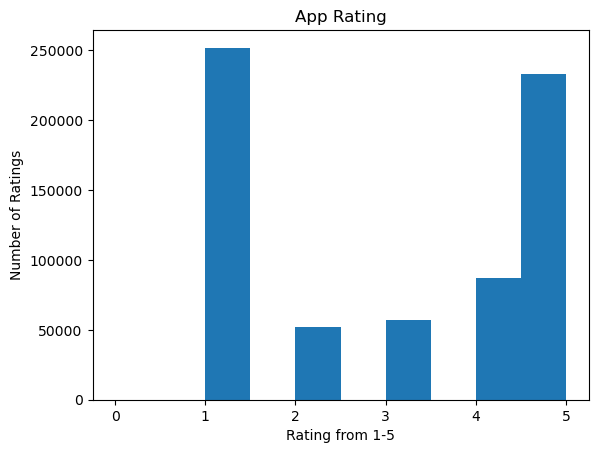

In [6]:
# Plotting a histogram just so we have a nice visual of how the ratings 1-5 compare in size
plt.hist(dating_df['Rating'])
plt.xlabel('Rating from 1-5')
plt.ylabel('Number of Ratings')
plt.title('App Rating')

In [7]:
# Checking the value counts of reviews per app
dating_df['App'].value_counts()

Tinder    526616
Bumble    102384
Hinge      52994
Name: App, dtype: int64

In [8]:
# Grouping by app to see how many of each review each app has
app_ratings2 = dating_df.groupby(['App', 'Rating'])['Rating'].count()
app_ratings2

App     Rating
Bumble  1          40412
        2           9674
        3           8841
        4          13589
        5          29868
Hinge   1          15920
        2           4509
        3           5289
        4           8617
        5          18659
Tinder  0              1
        1         195637
        2          38072
        3          42828
        4          65141
        5         184937
Name: Rating, dtype: int64

In [9]:
# Looking at the datatypes of each of our columns and checking for any null values
dating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681994 entries, 0 to 681993
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Name       681989 non-null  object
 1   Review     680642 non-null  object
 2   Rating     681994 non-null  int64 
 3   #ThumbsUp  681994 non-null  int64 
 4   Date&Time  681994 non-null  object
 5   App        681994 non-null  object
dtypes: int64(2), object(4)
memory usage: 31.2+ MB


### Pre-Processing our Text Data

Before jumping into modeling, I had to use NLP to pre-process the review data. This includes removing any stopwords or special characters, lowercasing and lemmetizing our text. All of the necessary steps are outlined below.

In [10]:
# Changing the contents in our 'Review' column from objects to strings so that we can do our pre-processing
dating_df['Review'] = dating_df['Review'].astype(str)

In [11]:
# Splitting the strings around our ',' delimiter
dating_df['Review'].str.split(',')

0                       [On this app i cant find a partner]
1         [Tinder would be so much better if we could sp...
2         [Still doesn't correctly notify matches or mes...
3         [Got banned because I updated my bio to say "I...
4                                                [Love it!]
                                ...                        
681989    [Useless - I'm in the UK and it tells me i'm o...
681990    [I can't get past the initial set up.  It won'...
681991    [This is incredible! A quality dating app for ...
681992            ["Over Water" ... Can't choose location.]
681993    [My entire town counts as "over water" and I c...
Name: Review, Length: 681994, dtype: object

In [12]:
# Verifying that our 'Review' column now includes strings
print(set(type(x) for x in dating_df['Review']))

{<class 'str'>}


In [183]:
# Taking a look at the text of one of the reviews (expecting some to be pretty funny)
dating_df['Review'][3]

'Got banned because I updated my bio to say "I feel like most girls on here are looking for plugs or sugar daddies and I\'m not for that" tinder team doesn\'t give the options to appel bans which is stupid.'

In [14]:
# Tokenizing the text in the 'Review' column of our dataset 
corpus = [word_tokenize(doc) for doc in dating_df['Review']]
print(corpus[0:4])

[['On', 'this', 'app', 'i', 'cant', 'find', 'a', 'partner'], ['Tinder', 'would', 'be', 'so', 'much', 'better', 'if', 'we', 'could', 'specify', 'the', 'race', 'that', 'we', 'are', 'looking', 'for', 'instead', 'of', 'swiping', 'unnecessarily', 'though', 'EVERYONE'], ['Still', 'does', "n't", 'correctly', 'notify', 'matches', 'or', 'messages', '.', 'It', "'s", 'a', 'monopoly', 'so', 'expect', 'zero', 'improvement', 'in', 'functionality', '.', 'Overpriced', '.', 'The', 'recently', 'added', 'features', 'like', 'date', 'night', 'ask', 'infantile', 'and', 'western', 'culture', 'based', 'questions', '.', 'Western', 'dating', 'culture', 'is', 'pure', 'evil', '.', 'The', 'marketing', 'tactics', 'are', 'designed', 'to', 'manipulate', 'and', 'extract', 'money', 'from', 'men', 'and', 'while', 'hiding', 'how', 'the', 'app', 'works', '.', 'An', 'evil', 'company', 'enabled', 'by', 'unregulated', 'capitalism/psychopathy', '.'], ['Got', 'banned', 'because', 'I', 'updated', 'my', 'bio', 'to', 'say', '``',

In [15]:
# Flattening our corpus for a better understanding of what it entails
flattenedcorpus_tokens = pd.Series(list(itertools.chain(*corpus)))
print(flattenedcorpus_tokens.shape)

(12844076,)


In [16]:
# Getting a count of the amount of unique words/characters in our corpus
dictionary = pd.Series(
    flattenedcorpus_tokens.unique())
print(len(dictionary))

143983


In [17]:
# Looking at the value counts of those words/characters
# Definitely have some mis-spelled words, acronyms...a number of things that we will most likely be dropping
flattenedcorpus_tokens.value_counts()

.          609371
I          350851
to         342229
the        274477
,          253732
            ...  
fun😀            1
Acheson         1
salia           1
rythem          1
wya             1
Length: 143983, dtype: int64

In [18]:
# Looking at the top 30 of our flattened corpus
flattenedcorpus_tokens.value_counts()[0:30]

.         609371
I         350851
to        342229
the       274477
,         253732
and       250831
a         223815
app       221457
it        218551
n't       151779
you       142713
of        136740
for       135470
is        134807
!         114409
my        112080
in        100807
this       91801
's         89319
me         88833
have       88167
but        87310
on         87186
not        87038
that       83602
people     73397
with       72329
It         63321
do         60447
get        57307
dtype: int64

In [19]:
flattenedcorpus_tokens.isin(['dating']).sum()

25440

In [20]:
flattenedcorpus_tokens.isin(['Dating']).sum()

879

In [21]:
flattenedcorpus_tokens.isin(['date']).sum()

5743

In [22]:
flattenedcorpus_tokens.isin(['Date']).sum()

118

In [23]:
# Looking at the tokens with one occurenece in the corpus
num_one_occurence = (flattenedcorpus_tokens.
                     value_counts() == 1).sum()
num_one_occurence

91263

In [24]:
# Have quite a few numeric tokens that we also won't need
dictionary[dictionary.str.isnumeric()]

243           18
263            5
451            2
466           24
511          286
           ...  
142448      1983
142948       235
143580      1975
143596    140000
143923      8122
Length: 809, dtype: object

In [25]:
# Instantiating stopwords
stop_words = stopwords.words('english')
print(stop_words[0:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [26]:
# Looping through our corpus to remove stopwords and lowercase the leftover tokens
def first_step_normalizer(doc):
    norm_text = [x.lower() for x in word_tokenize(doc) if ((x.isalpha()) & (x not in stop_words)) ]
    return norm_text

In [27]:
# Creating a new column with our normalized reviews
dating_df['Review_norm'] = dating_df['Review'].apply(first_step_normalizer)
dating_df.head()

,Name,Review,Rating,#ThumbsUp,Date&Time,App,Review_norm
0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder,"[on, app, cant, find, partner]"
1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,"[tinder, would, much, better, could, specify, ..."
2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,"[still, correctly, notify, matches, messages, ..."
3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder,"[got, banned, i, updated, bio, say, i, feel, l..."
4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,[love]


In [28]:
# Taking a look at that same review from earlier after it has been normalized
print(dating_df['Review_norm'].iloc[2])

['still', 'correctly', 'notify', 'matches', 'messages', 'it', 'monopoly', 'expect', 'zero', 'improvement', 'functionality', 'overpriced', 'the', 'recently', 'added', 'features', 'like', 'date', 'night', 'ask', 'infantile', 'western', 'culture', 'based', 'questions', 'western', 'dating', 'culture', 'pure', 'evil', 'the', 'marketing', 'tactics', 'designed', 'manipulate', 'extract', 'money', 'men', 'hiding', 'app', 'works', 'an', 'evil', 'company', 'enabled', 'unregulated']


In [29]:
# Checking the amount of unique tokens after removing stopwords.
# We initally had 143,861
norm_toks_flattened = pd.Series(list(
    itertools.chain(*dating_df['Review_norm'])))
new_dictionary = norm_toks_flattened.unique()
print(len(new_dictionary))

85186


In [30]:
# Instantiating our stemmers
p_stemmer = PorterStemmer()
s_stemmer = SnowballStemmer(language = 'english')
l_stemmer = LancasterStemmer()

In [31]:
# Setting a sample review to test our stemmers/lemmatizers with
sample_rev = dating_df['Review_norm'].iloc[2]
print(sample_rev)

['still', 'correctly', 'notify', 'matches', 'messages', 'it', 'monopoly', 'expect', 'zero', 'improvement', 'functionality', 'overpriced', 'the', 'recently', 'added', 'features', 'like', 'date', 'night', 'ask', 'infantile', 'western', 'culture', 'based', 'questions', 'western', 'dating', 'culture', 'pure', 'evil', 'the', 'marketing', 'tactics', 'designed', 'manipulate', 'extract', 'money', 'men', 'hiding', 'app', 'works', 'an', 'evil', 'company', 'enabled', 'unregulated']


In [32]:
# Trying out the snowball stemmer
snowball_stemmed_rev  = [s_stemmer.stem(token) 
                     for token in sample_rev]
print(snowball_stemmed_rev)

['still', 'correct', 'notifi', 'match', 'messag', 'it', 'monopoli', 'expect', 'zero', 'improv', 'function', 'overpr', 'the', 'recent', 'ad', 'featur', 'like', 'date', 'night', 'ask', 'infantil', 'western', 'cultur', 'base', 'question', 'western', 'date', 'cultur', 'pure', 'evil', 'the', 'market', 'tactic', 'design', 'manipul', 'extract', 'money', 'men', 'hide', 'app', 'work', 'an', 'evil', 'compani', 'enabl', 'unregul']


In [33]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aheinke/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/aheinke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/aheinke/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [34]:
# Looking at the POS tagging of our sample
pos_tag(sample_rev)

[('still', 'RB'),
 ('correctly', 'RB'),
 ('notify', 'JJ'),
 ('matches', 'NNS'),
 ('messages', 'NNS'),
 ('it', 'PRP'),
 ('monopoly', 'JJ'),
 ('expect', 'JJ'),
 ('zero', 'NN'),
 ('improvement', 'NN'),
 ('functionality', 'NN'),
 ('overpriced', 'VBD'),
 ('the', 'DT'),
 ('recently', 'RB'),
 ('added', 'VBD'),
 ('features', 'NNS'),
 ('like', 'IN'),
 ('date', 'NN'),
 ('night', 'NN'),
 ('ask', 'NN'),
 ('infantile', 'NN'),
 ('western', 'JJ'),
 ('culture', 'NN'),
 ('based', 'VBN'),
 ('questions', 'NNS'),
 ('western', 'JJ'),
 ('dating', 'JJ'),
 ('culture', 'NN'),
 ('pure', 'NN'),
 ('evil', 'VBZ'),
 ('the', 'DT'),
 ('marketing', 'NN'),
 ('tactics', 'NNS'),
 ('designed', 'VBN'),
 ('manipulate', 'JJ'),
 ('extract', 'JJ'),
 ('money', 'NN'),
 ('men', 'NNS'),
 ('hiding', 'VBG'),
 ('app', 'NN'),
 ('works', 'VBZ'),
 ('an', 'DT'),
 ('evil', 'JJ'),
 ('company', 'NN'),
 ('enabled', 'VBD'),
 ('unregulated', 'JJ')]

In [35]:
# Helper function to change nltk's part of speech tagging to a wordnet format
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [36]:
# Creates list of tokens with Wordnet format
wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(sample_rev))) 
print(wordnet_tagged)

[('still', 'r'), ('correctly', 'r'), ('notify', 'a'), ('matches', 'n'), ('messages', 'n'), ('it', None), ('monopoly', 'a'), ('expect', 'a'), ('zero', 'n'), ('improvement', 'n'), ('functionality', 'n'), ('overpriced', 'v'), ('the', None), ('recently', 'r'), ('added', 'v'), ('features', 'n'), ('like', None), ('date', 'n'), ('night', 'n'), ('ask', 'n'), ('infantile', 'n'), ('western', 'a'), ('culture', 'n'), ('based', 'v'), ('questions', 'n'), ('western', 'a'), ('dating', 'a'), ('culture', 'n'), ('pure', 'n'), ('evil', 'v'), ('the', None), ('marketing', 'n'), ('tactics', 'n'), ('designed', 'v'), ('manipulate', 'a'), ('extract', 'a'), ('money', 'n'), ('men', 'n'), ('hiding', 'v'), ('app', 'n'), ('works', 'v'), ('an', None), ('evil', 'a'), ('company', 'n'), ('enabled', 'v'), ('unregulated', 'a')]


In [37]:
# Instantiating our Wordnet lemmatizer
wnl = WordNetLemmatizer()
rev_lemmatized = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]
print(rev_lemmatized)

['still', 'correctly', 'notify', 'match', 'message', 'monopoly', 'expect', 'zero', 'improvement', 'functionality', 'overprice', 'recently', 'add', 'feature', 'date', 'night', 'ask', 'infantile', 'western', 'culture', 'base', 'question', 'western', 'dating', 'culture', 'pure', 'evil', 'marketing', 'tactic', 'design', 'manipulate', 'extract', 'money', 'men', 'hide', 'app', 'work', 'evil', 'company', 'enable', 'unregulated']


In [38]:
# Prefer what our Wordnet Lemmatizer returns, so we are going to apply this to our corpus
# Takes in untokenized document and returns fully normalized token list
def process_rev(rev):

    wnl = WordNetLemmatizer()


    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
        
    review_norm = [tok.lower() for tok in word_tokenize(rev) if ((tok.isalpha()) & (tok not in stop_words)) ]
    
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(review_norm))) 
    review_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]
    
    return review_norm

In [39]:
# Applying the code above to our Review column
fully_normalized_corpus = dating_df['Review'].apply(process_rev)

In [40]:
fully_normalized_corpus.head()

0                           [app, cant, find, partner]
1    [tinder, much, better, specify, race, look, in...
2    [still, correctly, notify, match, message, mon...
3    [get, ban, i, updated, bio, say, i, feel, girl...
4                                               [love]
Name: Review, dtype: object

In [41]:
flattened_fully_norm = pd.Series(list(itertools.chain(*fully_normalized_corpus)))
len(flattened_fully_norm.unique())

78067

In [42]:
flattened_fully_norm.value_counts()[0:30]

i          349643
app        226851
get        105208
good        87333
match       79306
people      76087
use         66262
tinder      62200
time        55411
great       45256
account     45113
work        44948
pay         44783
profile     43866
even        43828
message     40350
try         38664
log         35514
make        34582
like        33532
say         33218
ban         32324
go          32039
date        32002
see         30488
nice        30026
meet        28069
new         27992
swipe       27174
money       26935
dtype: int64

In [43]:
flattened_fully_norm.value_counts().tail(30)

impotency       1
forcedly        1
uttterly        1
unity           1
createnew       1
bloemfontein    1
withmy          1
interviewto     1
randamly        1
lendy           1
chiste          1
etna            1
pigheaded       1
iclude          1
mojjaaa         1
subnormales     1
encontrarán     1
ahad            1
sinceros        1
muchachos       1
vrsn            1
agreeing        1
thougn          1
jjg             1
inagain         1
vvvbn           1
creap           1
courpse         1
guid            1
wya             1
dtype: int64

In [44]:
flattened_fully_norm_value_counts = flattened_fully_norm.value_counts()
count_of_single_occurrences = (flattened_fully_norm_value_counts == 1).sum()
print(count_of_single_occurrences)

46494


In [45]:
# Checking the 200 mmost frequent words
freqdist = FreqDist(flattened_fully_norm)
 
most_common = freqdist.most_common(200)
most_common

[('i', 349643),
 ('app', 226851),
 ('get', 105208),
 ('good', 87333),
 ('match', 79306),
 ('people', 76087),
 ('use', 66262),
 ('tinder', 62200),
 ('time', 55411),
 ('great', 45256),
 ('account', 45113),
 ('work', 44948),
 ('pay', 44783),
 ('profile', 43866),
 ('even', 43828),
 ('message', 40350),
 ('try', 38664),
 ('log', 35514),
 ('make', 34582),
 ('like', 33532),
 ('say', 33218),
 ('ban', 32324),
 ('go', 32039),
 ('date', 32002),
 ('see', 30488),
 ('nice', 30026),
 ('meet', 28069),
 ('new', 27992),
 ('swipe', 27174),
 ('money', 26935),
 ('keep', 26682),
 ('find', 25850),
 ('bad', 25391),
 ('fake', 25141),
 ('want', 25061),
 ('love', 23460),
 ('give', 23374),
 ('still', 23256),
 ('facebook', 23158),
 ('way', 22938),
 ('really', 21978),
 ('well', 21906),
 ('day', 21794),
 ('back', 21353),
 ('show', 21070),
 ('fix', 20912),
 ('do', 20742),
 ('let', 20582),
 ('many', 20571),
 ('update', 20444),
 ('never', 20243),
 ('not', 20127),
 ('woman', 18906),
 ('reason', 18313),
 ('need', 18262),


In [46]:
# Turning our preprocessed data into a csv
fnc_output = fully_normalized_corpus.apply(" ".join)

fnc_output.to_csv('/Users/aheinke/Documents/Flatiron/phase-5-proj/dating_norm.csv')

In [47]:
fnc_output

0                                     app cant find partner
1         tinder much better specify race look instead s...
2         still correctly notify match message monopoly ...
3         get ban i updated bio say i feel girl look plu...
4                                                      love
                                ...                        
681989    useless i uk tell water let get run little tes...
681990    i get past initial set set neighborhood think ...
681991    incredible quality date app android boyfriend wya
681992                                water choose location
681993                    entire town count water i proceed
Name: Review, Length: 681994, dtype: object

In [48]:
# Pulling in our new dataset
corpus_df = pd.read_csv('/Users/aheinke/Documents/Flatiron/phase-5-proj/dating_norm.csv').drop(columns = ['Unnamed: 0'])
corpus_df

,Review
0,app cant find partner
1,tinder much better specify race look instead s...
2,still correctly notify match message monopoly ...
3,get ban i updated bio say i feel girl look plu...
4,love
...,...
681989,useless i uk tell water let get run little tes...
681990,i get past initial set set neighborhood think ...
681991,incredible quality date app android boyfriend wya
681992,water choose location


In [49]:
corpus_df['Review'].isnull().sum()

9998

In [50]:
corpus_df['Review'].fillna('', inplace = True)

In [51]:
# Convert our preprocessed strings (normalized token sequence) to a matrix of token counts
vec = CountVectorizer(min_df = 0.02, max_df = 0.98)
X = vec.fit_transform(corpus_df['Review'])

# .get_feature_names_out() useful attribute
countvec_df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names_out())
countvec_df.head()

,account,also,app,apps,back,bad,ban,best,cool,date,...,tinder,try,update,use,want,waste,way,well,woman,work
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,2,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# Downloading Vader from nltk so that we can look at sentiment scores
nltk.download('vader_lexicon')

# Creating an object of sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/aheinke/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [184]:
sentiment_scores = []

# Looping through each line of the dataset to get the sentiment score
for line in dating_df['Review']:
    score = sia.polarity_scores(line)
    sentiment_scores.append(score)

# Creating a new column in the dataset to store the sentiment scores
dating_df['Sentiment_Scores'] = sentiment_scores

In [185]:
dating_df

,Name,Review,Rating,#ThumbsUp,Date&Time,App,Review_norm,found_relationship,scores,compound,pos,neg,neu,type,New_Rating,Sentiment_Scores
0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder,"[on, app, cant, find, partner]",None,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,NEUTRAL,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,"[tinder, would, much, better, could, specify, ...",None,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.4902,0.126,0.000,0.874,POS,1,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp..."
2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,"[still, correctly, notify, matches, messages, ...",None,"{'neg': 0.149, 'neu': 0.773, 'pos': 0.078, 'co...",-0.7380,0.078,0.149,0.773,NEG,0,"{'neg': 0.149, 'neu': 0.773, 'pos': 0.078, 'co..."
3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...",None,"{'neg': 0.143, 'neu': 0.802, 'pos': 0.056, 'co...",-0.5994,0.056,0.143,0.802,NEG,0,"{'neg': 0.143, 'neu': 0.802, 'pos': 0.056, 'co..."
4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,[love],None,"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp...",0.6696,0.818,0.000,0.182,POS,1,"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681989,A Google user,Useless - I'm in the UK and it tells me i'm ov...,2,5,12-07-2017 01:44,Hinge,"[useless, i, uk, tells, water, wo, let, get, r...",None,"{'neg': 0.141, 'neu': 0.859, 'pos': 0.0, 'comp...",-0.7096,0.000,0.141,0.859,NEG,0,"{'neg': 0.141, 'neu': 0.859, 'pos': 0.0, 'comp..."
681990,Brian Shook,I can't get past the initial set up. It won't...,1,11,12-07-2017 01:36,Hinge,"[i, ca, get, past, initial, set, it, wo, set, ...",None,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,NEUTRAL,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
681991,A Google user,This is incredible! A quality dating app for A...,5,1,12-07-2017 01:32,Hinge,"[this, incredible, a, quality, dating, app, an...",None,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,NEUTRAL,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
681992,A Google user,"""Over Water"" ... Can't choose location.",2,8,12-07-2017 01:28,Hinge,"[over, water, ca, choose, location]",None,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,NEUTRAL,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [59]:
# Creating one final column that outlines the sentiment of each review
dating_df['type'] = ''
dating_df.loc[dating_df.compound > 0,'type'] = 'POS'
dating_df.loc[dating_df.compound == 0,'type'] = 'NEUTRAL'
dating_df.loc[dating_df.compound < 0,'type'] = 'NEG'
dating_df.head()

,Name,Review,Rating,#ThumbsUp,Date&Time,App,Review_norm,found_relationship,scores,compound,pos,neg,neu,type
0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder,"[on, app, cant, find, partner]",None,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,NEUTRAL
1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,"[tinder, would, much, better, could, specify, ...",None,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.4902,0.126,0.000,0.874,POS
2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,"[still, correctly, notify, matches, messages, ...",None,"{'neg': 0.149, 'neu': 0.773, 'pos': 0.078, 'co...",-0.7380,0.078,0.149,0.773,NEG
3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...",None,"{'neg': 0.143, 'neu': 0.802, 'pos': 0.056, 'co...",-0.5994,0.056,0.143,0.802,NEG
4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,[love],None,"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp...",0.6696,0.818,0.000,0.182,POS


In [60]:
# Looping through to determine how many postive, negative, and neutral reviews our dataset contains
length = dating_df.shape
(rows, cols) = length
pos = 0
neg = 0
neutral = 0
for i in range(0, rows):
    if dating_df.loc[i][12] == 'POS':
        pos = pos + 1
    if dating_df.loc[i][12] == 'NEG':
        neg = neg + 1
    if dating_df.loc[i][12] == 'NEUTRAL':
        neutral = neutral + 1
print('Positive :' + str(pos) + '  Negative :' + str(neg) + '   Neutral :' + str(neutral))

Positive :0  Negative :0   Neutral :0


In [61]:
# Breaking these numbers down by app
app_sentiment = dating_df.groupby(['App', 'type'])['type'].count()
app_sentiment

App     type   
Bumble  NEG         31841
        NEUTRAL     15661
        POS         54882
Hinge   NEG         13113
        NEUTRAL      7063
        POS         32818
Tinder  NEG        150426
        NEUTRAL    116767
        POS        259423
Name: type, dtype: int64

In [62]:
# For some of the models that I will be using, I am defining a function to map the rating values to 0 or 1
# Ratings 1-2 will be '0' or Negative, ratings 3-5 will be '1' or positive
def map_rating(rating):
    if rating <= 2:
        return 0
    else:
        return 1

# Applying the mapping function to the 'Rating' column to create a new column called 'New_Rating'
# We will use this column as a reference for our models
dating_df['New_Rating'] = dating_df['Rating'].apply(map_rating)
dating_df.head()

,Name,Review,Rating,#ThumbsUp,Date&Time,App,Review_norm,found_relationship,scores,compound,pos,neg,neu,type,New_Rating
0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder,"[on, app, cant, find, partner]",None,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,NEUTRAL,1
1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,"[tinder, would, much, better, could, specify, ...",None,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.4902,0.126,0.000,0.874,POS,1
2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,"[still, correctly, notify, matches, messages, ...",None,"{'neg': 0.149, 'neu': 0.773, 'pos': 0.078, 'co...",-0.7380,0.078,0.149,0.773,NEG,0
3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...",None,"{'neg': 0.143, 'neu': 0.802, 'pos': 0.056, 'co...",-0.5994,0.056,0.143,0.802,NEG,0
4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,[love],None,"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp...",0.6696,0.818,0.000,0.182,POS,1


In [63]:
# Creating a smaller dataset with just the information that we need to run through our models
# It includes the Ratings, Apps, and our pre-processed reviews
dating_df2 = dating_df[['Rating','App', 'Review_norm', 'New_Rating']]
dating_df2.head()

,Rating,App,Review_norm,New_Rating
0,5,Tinder,"[on, app, cant, find, partner]",1
1,3,Tinder,"[tinder, would, much, better, could, specify, ...",1
2,1,Tinder,"[still, correctly, notify, matches, messages, ...",0
3,2,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...",0
4,5,Tinder,[love],1


In [64]:
dating_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681994 entries, 0 to 681993
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Rating       681994 non-null  int64 
 1   App          681994 non-null  object
 2   Review_norm  681994 non-null  object
 3   New_Rating   681994 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 20.8+ MB


### Baseline Model

I started off with a simple logistic regression as our baseline, because it is relatively easy to implement and can provide good accuracy for binary classification problems like sentiment analysis. It works by modeling the probability of a particular sentiment (e.g. positive or negative) given the input features (e.g. words or phrases in a text). The logistic function is used to transform the output of the model to a probability between 0 and 1, which can then make a binary prediction.

In [65]:
# Going to run a logistic regression on our data
y = dating_df2['New_Rating']
X = dating_df2.drop(['New_Rating', 'App', 'Review_norm'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [66]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [67]:
y_hat_train = logreg.predict(X_train)

train_residuals = np.abs(y_train - y_hat_train)
print(pd.Series(train_residuals, name = 'Residuals (counts)').value_counts())
print()
print(pd.Series(train_residuals, name = 'Residuals (proportions)').value_counts(normalize = True))
print("Accuracy Score: ", acc_score)

0    283369
1    228126
Name: Residuals (counts), dtype: int64

0    0.554002
1    0.445998
Name: Residuals (proportions), dtype: float64


In [186]:
y_hat_test = logreg.predict(X_test)

test_residuals = np.abs(y_test - y_hat_test)
print(pd.Series(test_residuals, name = 'Residuals (counts)').value_counts())
print()
print(pd.Series(test_residuals, name = 'Residuals (proportions)').value_counts(normalize = True))
print("Accuracy Score: ", acc_score)

/Users/aheinke/.conda/envs/cremedelaclem/cremedelaclem2/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


ValueError: X has 100 features, but LogisticRegression is expecting 1 features as input.

However, because of it's limitations, assuming that the relationship between the input features and the output variable is linear, which is not always the case. Thus, the accuracy score of the model only hit a 55%. 

So we are going to try some other, more complex models, to see if we can get this score up!


### Second Model

For my second model I went with a Multinomial Naive Bayes (NB) classifier, as it can be a good option for sentiment analysis, especially when working with text data, because it works well with discrete count-based data like word frequencies. The algorithm is also simple and efficient and can handle high-dimensional sparse data well.

Multinomial NB is based on the Bayes theorem and works by calculating the probability of a document belonging to a certain class (positive or negative sentiment) given its features (words in the text). It does this by using a probabilistic model that assumes that the features are conditionally independent given the class label. However this assumption that features are independent of each other is not always true of text data.

In [69]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words = 'english', ngram_range = (1,1), tokenizer = token.tokenize)
text_counts = cv.fit_transform(dating_df['Review'])

X_train, X_test, Y_train, Y_test = train_test_split(text_counts, dating_df2['New_Rating'], test_size = 0.3,\
                                                    random_state = 5)

MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

predicted = MNB.predict(X_test)
acc_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracy Score: ", acc_score)

Accuracy Score:  0.8552485593771231


But we are already getting a much better score than our Logistic Regression, so we are on the right track!


### Third Model

For my third model I went with a Naive Bayes, a simple yet effective algorithm that is commonly used for sentiment analysis. It works by calculating the probability of each word in a text belonging to a certain class (positive or negative) and then combining these probabilities to determine the overall sentiment of the text.

In [70]:
# Naive Bayes
# Assuming your preprocessed data is in a pandas dataframe called dating_df
X = dating_df2['Review_norm']  # Text data
y = dating_df2['New_Rating']    # Target variable (positive or negative)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Convert labels into numerical labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Convert text data into numerical features using a CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(map(str, X_train))
X_test = vectorizer.transform(map(str, X_test))

# Train a Naive Bayes classifier on the training set
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = naive_bayes.predict(X_test)
acc = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc}")
print("Confusion matrix:\n", confusion_mat)

Accuracy: 0.8588919273601713
Confusion matrix:
 [[51559  9281]
 [ 9966 65593]]


The Naive Bayes did a liiitle bit better, but wondering if we can still push this or if we've plateaued...


### Fourth Model

For the fourth model we are going with a Linear SVC, which can be a good choice for sentiment analysis as well. A Linear SVC is a type of Support Vector Machine (SVM) that works well on high-dimensional datasets and is known for its ability to handle sparse data. Like logistic regression and Multinomial Naive Bayes, Linear SVC can also be used for binary and multi-class classification tasks, making it a versatile model for sentiment analysis.

In [71]:
# Assuming your preprocessed data is in a pandas dataframe called dating_df2
X = dating_df2['Review_norm']  # Text data
y = dating_df2['New_Rating']    # Target variable (positive or negative)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Convert text data into numerical features using a TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train.astype(str))
X_test = vectorizer.transform(X_test.astype(str))

# Train a LinearSVC classifier on the training set
clf = LinearSVC()
clf.fit(X_train, y_train)

# Use the trained classifier to predict the sentiment of the text in the testing set
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion matrix:\n", confusion_mat)

Accuracy: 0.8695151723986246
Confusion matrix:
 [[52727  8118]
 [ 9680 65874]]


This is our best score yet! So maybe this is as far as we can push it, but I'm going to run a few more models just to be sure.


In [74]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dating_df2['Review_norm'], dating_df2['New_Rating'],\
                                                    test_size = 0.2, random_state = 42)

# Convert the text data into numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train.astype(str))
X_test = vectorizer.transform(X_test.astype(str))

# Train a Random Forest Classifier on the training set
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Use the trained classifier to predict the sentiment of the text in the testing set
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy_sc = accuracy_score(y_test, y_pred)
con_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy_sc)
print("Confusion matrix:\n", con_mat)

Accuracy: 0.8685034347759147
Confusion matrix:
 [[54976  5864]
 [12072 63487]]


In [75]:
# Load the data and split into training and testing sets
X = dating_df2['Review_norm']
y = dating_df2['New_Rating'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Convert the text data into numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train.astype(str))
X_test = vectorizer.transform(X_test.astype(str))

# Train a Gradient Boosting Classifier on the training set
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

# Use the trained classifier to predict the sentiment of the text in the testing set
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
acc_sc = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc_sc)
print("Confusion matrix:\n", confusion_mat)

Accuracy: 0.8061496052023842
Confusion matrix:
 [[41823 19017]
 [ 7424 68135]]


Recurrent Neural Networks (RNNs): RNNs are a type of neural network that can be used for sentiment analysis. They work by analyzing the sequence of words in a text and using this information to predict the sentiment of the text.

In [76]:
# Assuming your preprocessed data is in a pandas dataframe called dating_df
X = dating_df2['Review_norm']  # Text data
y = dating_df2['New_Rating']    # Target variable (positive or negative)

# Tokenize the text data
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequences, maxlen = 100)

# Convert target variable to categorical data
y = to_categorical(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Train a simple RNN
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim = 10000, output_dim = 64, input_length = 100))
rnn_model.add(LSTM(64, return_sequences = True))
rnn_model.add(GlobalMaxPooling1D())
rnn_model.add(Dense(64, activation = 'relu'))
rnn_model.add(Dense(2, activation = 'softmax'))
rnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
rnn_model.fit(X_train, y_train, epochs = 10, batch_size = 128, validation_split = 0.2)

# Evaluate the performance of the models on the testing set
rnn_acc = accuracy_score(y_test.argmax(axis = 1), rnn_model.predict(X_test).argmax(axis = 1))
rnn_confusion_mat = confusion_matrix(y_test.argmax(axis = 1), rnn_model.predict(X_test).argmax(axis = 1))

print("RNN Accuracy:", rnn_acc)
print("RNN Confusion matrix:\n", rnn_confusion_mat)

2023-04-18 15:29:32.754590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
3410/3410 [==============================] - 196s 57ms/step - loss: 0.3122 - accuracy: 0.8683 - val_loss: 0.2878 - val_accuracy: 0.8822
Epoch 2/10
3410/3410 [==============================] - 209s 61ms/step - loss: 0.2766 - accuracy: 0.8869 - val_loss: 0.2839 - val_accuracy: 0.8834
Epoch 3/10
3410/3410 [==============================] - 227s 67ms/step - loss: 0.2615 - accuracy: 0.8944 - val_loss: 0.2873 - val_accuracy: 0.8836
Epoch 4/10
3410/3410 [==============================] - 229s 67ms/step - loss: 0.2477 - accuracy: 0.9009 - val_loss: 0.2920 - val_accuracy: 0.8823
Epoch 5/10
3410/3410 [==============================] - 224s 66ms/step - loss: 0.2342 - accuracy: 0.9071 - val_loss: 0.3040 - val_accuracy: 0.8816
Epoch 6/10
3410/3410 [==============================] - 219s 64ms/step - loss: 0.2203 - accuracy: 0.9132 - val_loss: 0.3178 - val_accuracy: 0.8795
Epoch 7/10
3410/3410 [==============================] - 227s 66ms/step - loss: 0.2069 - accuracy: 0.9192 - val_loss: 0

Although this modelm gave us our highest score of 88%, it also took the longest to run and so is therefore not as efficient as some of our other models.

### Final Model

So for my final model, I decided to go with the Linear SVC as it works well on high-dimensional datasets and is known for its ability to handle sparse data, plus can also be used for binary and multi-class classification tasks, making it a versatile model for sentiment analysis. It had also given me a pretty high accuracy score of 87%, but at a much faster rate than the RNN, and gave high precision (0 = 84%, 1 = 89%), recall (0 = 87%, 1 = 87%), and f1 (0 = 86%, 1 = 88%) scores. So compared to my baseline it was a significant improvement!

In [ ]:
# Doing a cross validation of our final and so generating some dummy data
X, y = make_classification(n_samples = 1000, n_features = 10, n_informative = 5, n_classes = 2, random_state = 42)

# Instantiating the Linear SVC model
svc = LinearSVC()

# Performing a 5-fold cross-validation
scores = cross_val_score(svc, X, y, cv = 5)

# Printing the average accuracy and standard deviation across the 5 folds
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
# Performing k-fold cross-validation on the Linear SVC model
scores = cross_val_score(clf, X, y, cv = 5)
print("Cross-validation scores:", scores)
print("Average accuracy:", scores.mean())

# Calculating precision, recall, F1 score, and confusion matrix
y_pred = clf.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

In [ ]:
# Playing around with some sentiments, using 'found relationship' as an example
# If the review fit's our 'found relationship parameter'
def found_relationship(content):
    match = re.search(r"(met|found).{0,20}(husband|wife|love|partner)", content, flags=re.I)
    if match:
        return match.group(0)

In [ ]:
dating_df['found_relationship'] = dating_df['Review'].fillna("").apply(found_relationship)
dating_df[(dating_df['found_relationship'].notna()) & (dating_df['Rating'] >= 4)]

In [77]:
tinder_pos_df = dating_df2[(dating_df2['App'] == 'Tinder') & (dating_df2['New_Rating'] == 1)]
tinder_pos_df.head()

,Rating,App,Review_norm,New_Rating
0,5,Tinder,"[on, app, cant, find, partner]",1
1,3,Tinder,"[tinder, would, much, better, could, specify, ...",1
4,5,Tinder,[love],1
5,5,Tinder,"[good, app]",1
6,5,Tinder,"[its, great, app, find, expensive]",1


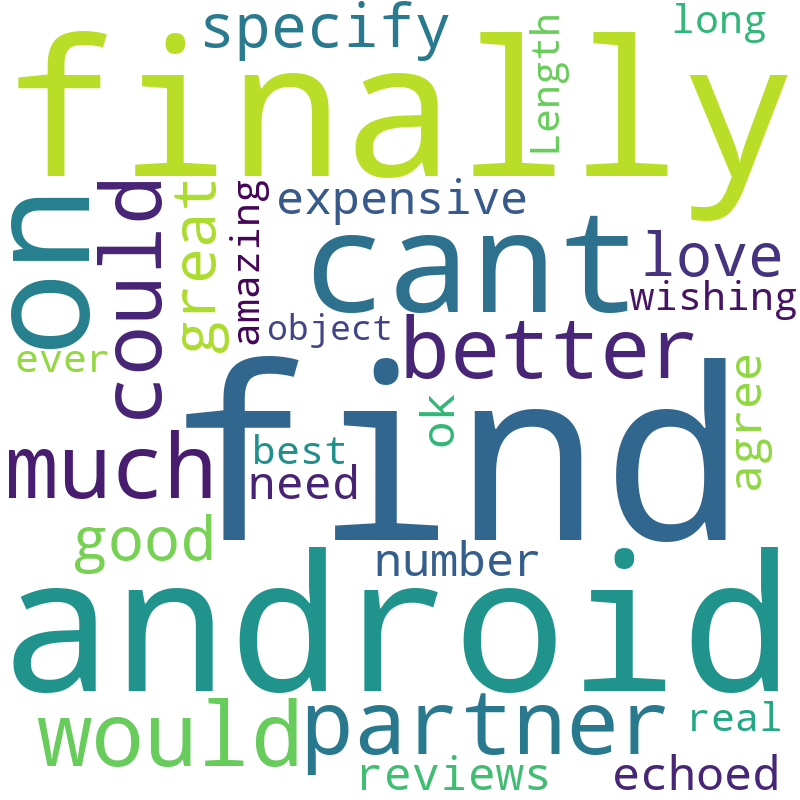

In [78]:
wordcloud = WordCloud(width = 800, height = 800, stopwords = ['app', 'tinder', 'i', 'its', 'Review_norm', 'upda',\
                                                              'Name', 'dtype'],
                      background_color = 'white').generate(str(tinder_pos_df['Review_norm']))
wordcloud.to_image()

In [79]:
tinder_neg_df = dating_df2[(dating_df2['App'] == 'Tinder') & (dating_df2['New_Rating'] == 0)]
tinder_neg_df.head()

,Rating,App,Review_norm,New_Rating
2,1,Tinder,"[still, correctly, notify, matches, messages, ...",0
3,2,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...",0
7,1,Tinder,"[just, tested, originally, noticing, flux, esc...",0
10,2,Tinder,"[i, know, i, banned, happened, i, really, unde...",0
12,1,Tinder,"[they, banned, account, without, anything]",0


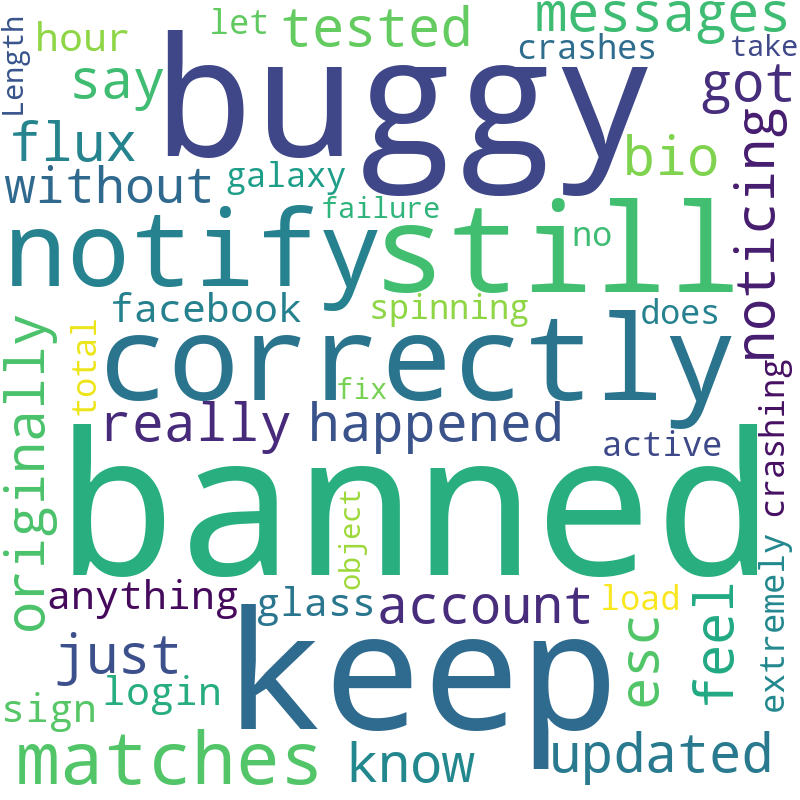

In [142]:
wordcloud = WordCloud(width = 800, height = 800, stopwords = ['app', 'tinder', 'i', 'its', 'Review_norm', 'upda',\
                                                              'Name', 'dtype', 'y', 'l', 'they', 'unde'],
                      background_color = 'white').generate(str(tinder_neg_df['Review_norm']))
wordcloud.to_image()

In [81]:
bumble_pos_df = dating_df2[(dating_df2['App'] == 'Bumble') & (dating_df2['New_Rating'] == 1)]
bumble_pos_df.head()

,Rating,App,Review_norm,New_Rating
526616,4,Bumble,"[dacă, nu, ar, cere, mereu, bani, pentru, oric...",1
526620,5,Bumble,"[pretty, good, far]",1
526624,4,Bumble,"[not, paying, member, so, far, i, found, ladie...",1
526627,3,Bumble,"[ms, wolfe, subsidizing, abortions, texas]",1
526629,5,Bumble,[love],1


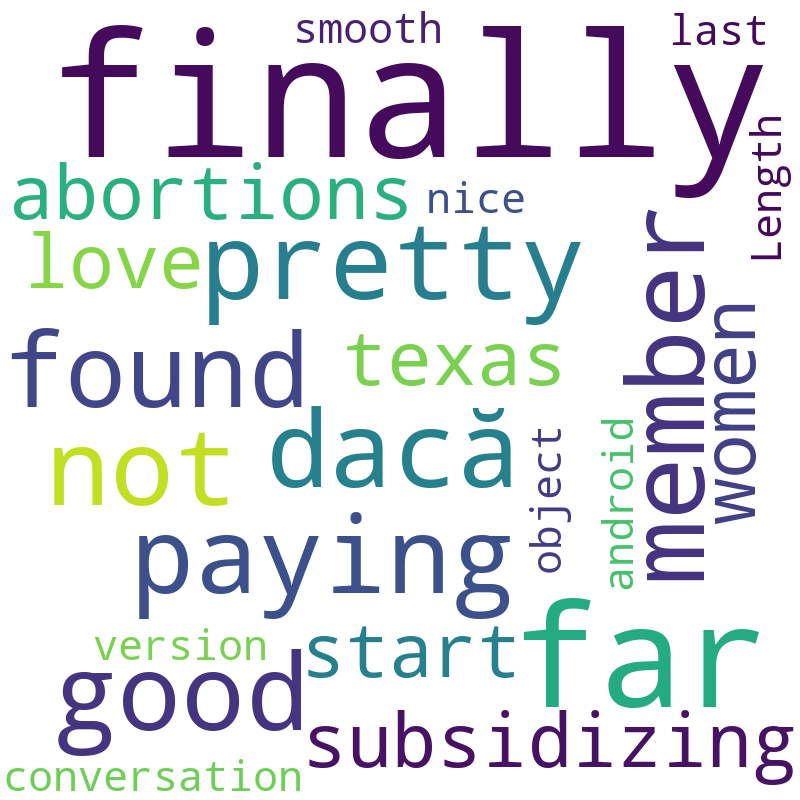

In [144]:
wordcloud = WordCloud(width = 800, height = 800, stopwords = ['app', 'bumble', 'i', 'its', 'Review_norm', 'ms', 'nu',\
                                                              'so', 'ar', 'at', 'lov', 'oric', 'mereu', 'pentru',\
                                                              'dtype', 'cere', 'bani', 'ladie', 'wolfe', 'Name'],
                      background_color = 'white').generate(str(bumble_pos_df['Review_norm']))
wordcloud.to_image()

In [83]:
bumble_neg_df = dating_df2[(dating_df2['App'] == 'Bumble') & (dating_df2['New_Rating'] == 0)]
bumble_neg_df.head()

,Rating,App,Review_norm,New_Rating
526617,1,Bumble,"[ca, seem, log, account, i, tried, many, diffe...",0
526618,1,Bumble,"[limited, views, without, paying, money, fake,...",0
526619,1,Bumble,"[this, trusted, worst, app, this, app, trust, ...",0
526621,1,Bumble,"[just, money, grab, i, used, love, app, starte...",0
526622,1,Bumble,"[the, app, crapp, if, i, switch, away, app, an...",0


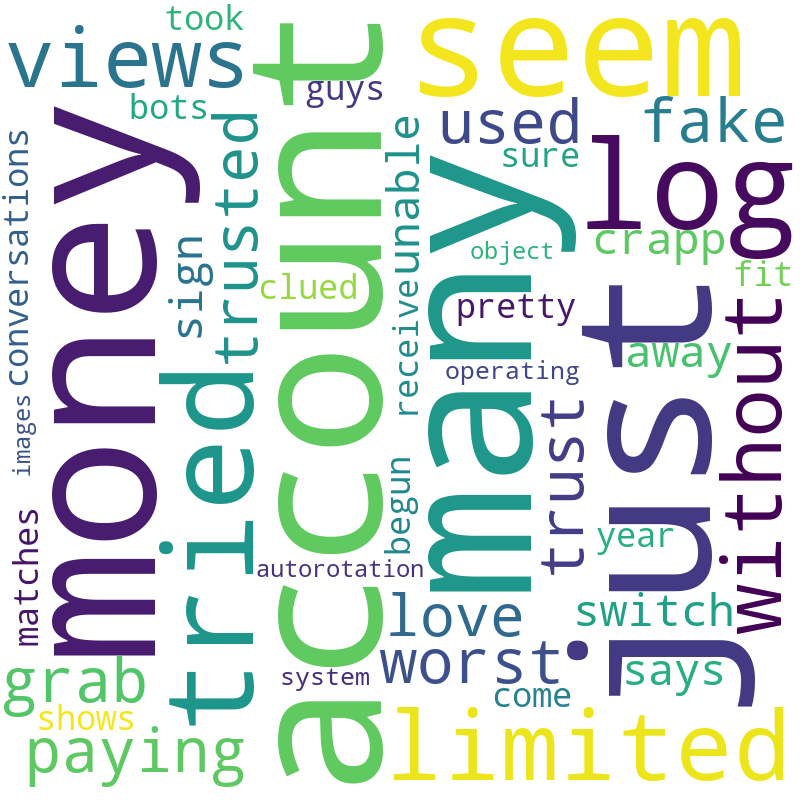

In [145]:
wordcloud = WordCloud(width = 800, height = 800, stopwords = ['app', 'bumble', 'i', 'its', 'Review_norm', 'ms', 'nu',\
                                                             'so', 'ar', 'at', 'lov', 'oric', 'cl', 'the', 'an',\
                                                              'dtype', 'diffe', 'my', 'if', 'it', 'this', 'starte',\
                                                              'Name', 'Length', 'android', 'facebook', 'ca'],
                      background_color = 'white').generate(str(bumble_neg_df['Review_norm']))
wordcloud.to_image()

In [85]:
hinge_pos_df = dating_df2[(dating_df2['App'] == 'Hinge') & (dating_df2['New_Rating'] == 1)]
hinge_pos_df.head()

,Rating,App,Review_norm,New_Rating
629000,5,Hinge,[perfect],1
629002,5,Hinge,"[found, someone, and, counts]",1
629004,4,Hinge,"[needs, darkmode, so, white, it, flashes, scre...",1
629009,3,Hinge,"[okay, sets]",1
629012,3,Hinge,"[still, new, app, feels, great, use]",1


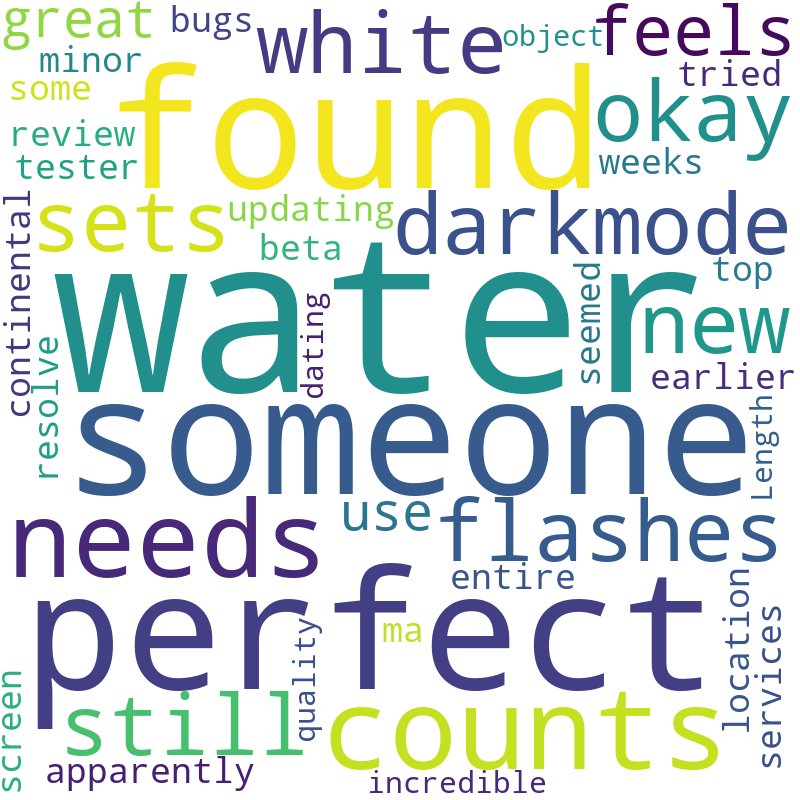

In [86]:
wordcloud = WordCloud(width = 800, height = 800, stopwords = ['app', 'i', 'it', 'hinge', 'Review_norm', 'they', 'my',\
                                                             'this', 'popu', 'wo', 'showi', 'r', 'an', 'c', 'a', 'us',\
                                                             'dtype', 'scre', 'Name', 'so', 'and'],
                      background_color = 'white').generate(str(hinge_pos_df['Review_norm']))
wordcloud.to_image()

In [87]:
hinge_neg_df = dating_df2[(dating_df2['App'] == 'Hinge') & (dating_df2['New_Rating'] == 0)]
hinge_neg_df.head()

,Rating,App,Review_norm,New_Rating
629001,2,Hinge,"[there, may, truth, hinge, claims, app, delete...",0
629003,1,Hinge,"[this, app, horribly, messed, they, take, popu...",0
629005,1,Hinge,"[horrible, app, this, app, hinge, worth, zero,...",0
629006,1,Hinge,"[it, called, dating, app, reason, date, great,...",0
629007,1,Hinge,"[constantly, glitching, losing, matches, showi...",0


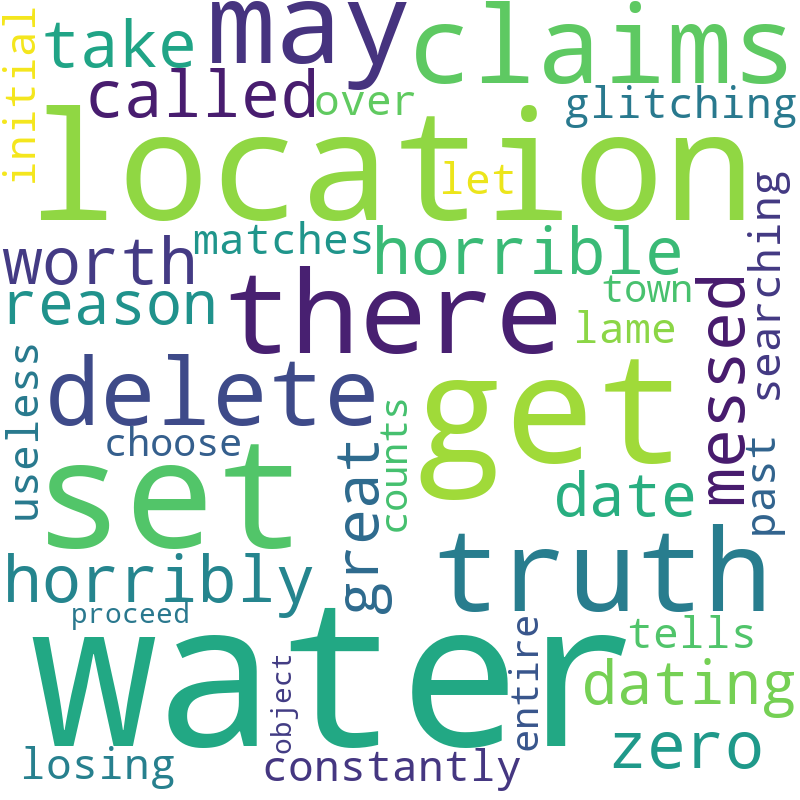

In [147]:
wordcloud = WordCloud(width = 800, height = 800, stopwords = ['app', 'i', 'it', 'hinge', 'Review_norm', 'they', 'my',\
                                                             'this', 'popu', 'wo', 'showi', 'r', 'ca', 'Name',\
                                                              'dtype', 'Length', 'uk'],
                      background_color = 'white').generate(str(hinge_neg_df['Review_norm']))
wordcloud.to_image()

In [89]:
dating_df_mod = pd.DataFrame(dating_df, columns = ['Rating', 'App', 'Review_norm', 'type'])
dating_df_mod.head()

,Rating,App,Review_norm,type
0,5,Tinder,"[on, app, cant, find, partner]",NEUTRAL
1,3,Tinder,"[tinder, would, much, better, could, specify, ...",POS
2,1,Tinder,"[still, correctly, notify, matches, messages, ...",NEG
3,2,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...",NEG
4,5,Tinder,[love],POS


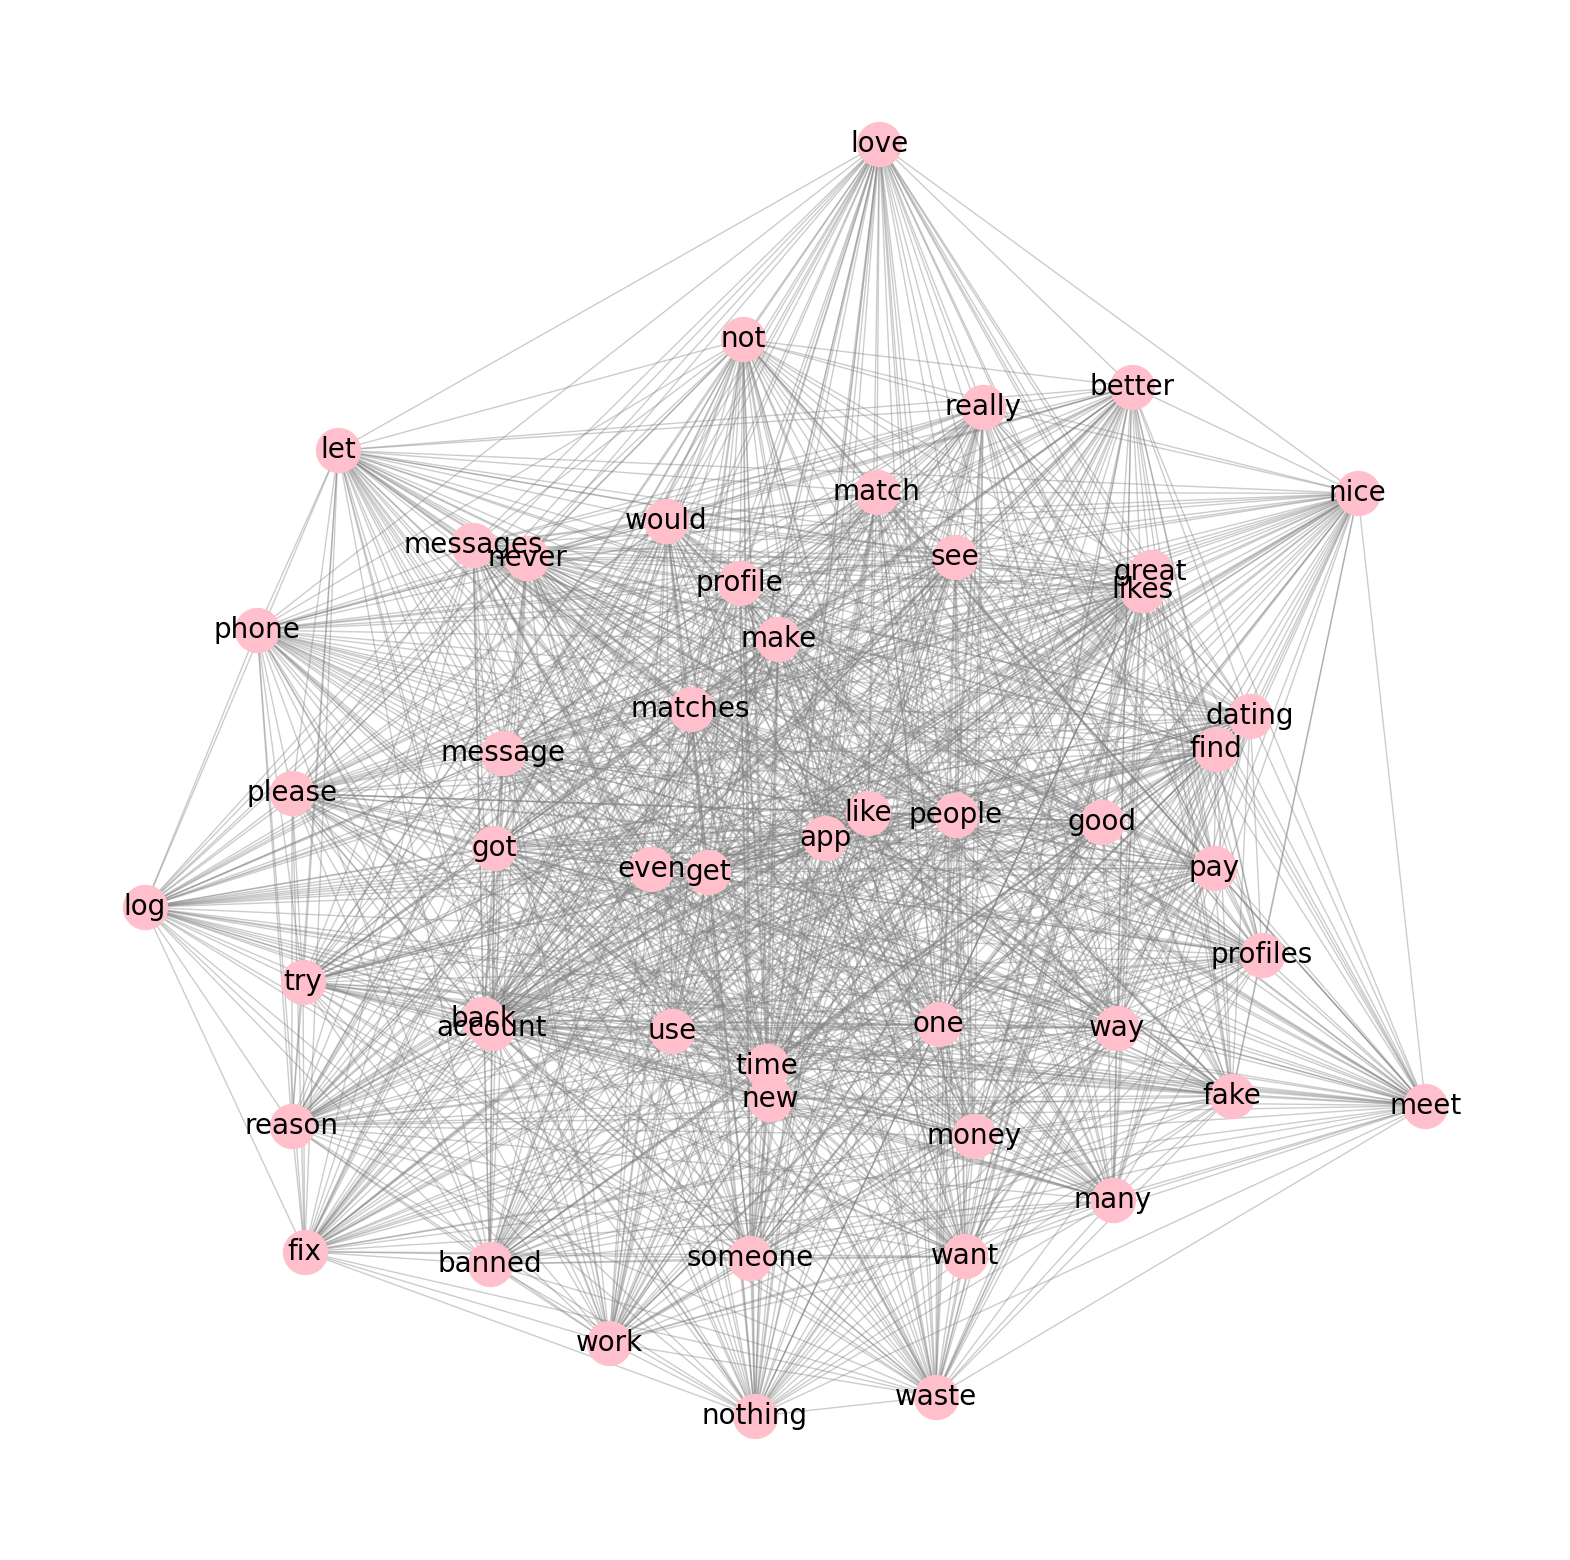

In [121]:
import plotly.graph_objects as go
from collections import Counter
import networkx as nx
# Create a list of all words in the corpus
all_words = []
for text in dating_df2['Review_norm']:
    if isinstance(text, list):  # check if text is already a list
        words = text
    else:
        words = text.split()  # otherwise, split text into individual words
    all_words.extend(words)

# Create a list of the most frequent words
stop_words = ['the', 'and', 'to', 'i', 'it', 'ca', 'tinder', 'this', 'wo', 'facebook', 'still']
freq_words = [word for word, count in Counter(all_words).most_common(60) if word not in stop_words]

# Create a co-occurrence matrix
co_occurrence_matrix = np.zeros((len(freq_words), len(freq_words)))
for text in dating_df2['Review_norm']:
    if isinstance(text, list):  # check if text is already a list
        words = text
    else:
        words = text.split()  # otherwise, split text into individual words
    for i, word1 in enumerate(freq_words):
        if word1 in words:
            for j, word2 in enumerate(freq_words):
                if word2 in words and i != j:
                    co_occurrence_matrix[i][j] += 1

# Create a network graph
G = nx.Graph()
for i, word in enumerate(freq_words):
    G.add_node(word)
    for j, word2 in enumerate(freq_words):
        if co_occurrence_matrix[i][j] > 0:
            G.add_edge(word, word2, weight = co_occurrence_matrix[i][j])

# Visualize the graph
plt.figure(figsize = (20,20))
pos = nx.spring_layout(G, k = 0.5, iterations = 50)
nx.draw_networkx_nodes(G, pos, node_size = 1000, node_color = 'pink')
nx.draw_networkx_edges(G, pos, alpha = 0.4, edge_color = 'gray')
nx.draw_networkx_labels(G, pos, font_size = 20, font_family = 'sans-serif')
plt.axis('off')
plt.show()

In [178]:
app_df = dating_df.loc[(dating_df['type'] == 'POS'), ['Name', 'Review_norm', 'App']]
app_df

,Name,Review_norm,App
1,Norman Johnson,"[tinder, would, much, better, could, specify, ...",Tinder
4,Arthur Magamedov,[love],Tinder
5,Lukas Rukštelis,"[good, app]",Tinder
6,kadija shaikh,"[its, great, app, find, expensive]",Tinder
7,Joe burns,"[just, tested, originally, noticing, flux, esc...",Tinder
...,...,...,...
681972,Zachary Srebnick,"[updating, earlier, review, location, services...",Hinge
681973,Mike Davis,"[i, beta, tester, weeks, some, minor, bugs, ma...",Hinge
681974,Jennifer A.,"[why, earth, would, allow, people, facebook, j...",Hinge
681980,A M,"[like, many, others, ca, get, past, first, scr...",Hinge


In [179]:
import copy
from sklearn.metrics.pairwise import cosine_similarity
text = input()
# text = ' '.join(process_doc(text))
# load data and make a copy
# combined_data = tinder_pos_df
corpus_ = copy.deepcopy(app_df)
# add input to dataframe
corpus_.loc[len(corpus_.index)] = text
corpus_['Review_norm'] = corpus_['Review_norm'].apply(lambda x: ' '.join(x))
c = vec.fit_transform(corpus_['Review_norm'])
# for loop to get cosine similarity
top = []
for i in c:
    cos = cosine_similarity(i.reshape(1, -1),c[-1].reshape(1, -1))[0][0]
    top.append(cos)
# remove input similarity value to itself
top.pop()
#find the index with highest similarity
ind_1 = np.argmax(top)
# 2nd best
top[ind_1] = -1 # ensure 1st choice is not an option
ind_2 = np.argmax(top)
# 3rd best
top[ind_2] = -1 # ensure 2nd choice is not an option
ind_3 = np.argmax(top)
#return quotes
idx = [ind_1, ind_2, ind_3]
for n, i in enumerate(idx, 1):
    print(f'#{n}\n{app_df.iloc[i, 1:]}\n')

sex
#1
Review_norm    [tinder, would, much, better, could, specify, ...
App                                                       Tinder
Name: 1, dtype: object

#2
Review_norm    [love]
App            Tinder
Name: 4, dtype: object

#3
Review_norm    [good, app]
App                 Tinder
Name: 5, dtype: object



In [182]:
dating_df.iloc[600042]

Name                                                      A Google user
Review                just abuse from trolling women going "youre no...
Rating                                                                1
#ThumbsUp                                                             1
Date&Time                                              25-01-2019 02:24
App                                                              Bumble
Review_norm           [abuse, trolling, women, going, youre, real, f...
found_relationship                                                 None
scores                {'neg': 0.167, 'neu': 0.715, 'pos': 0.118, 'co...
compound                                                        -0.3008
pos                                                               0.118
neg                                                               0.167
neu                                                               0.715
type                                                            